Model loaded from resnet18_pneumonia2.pth
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266


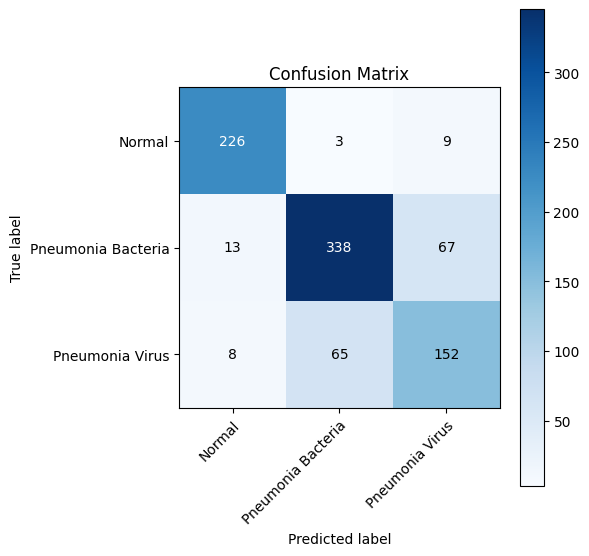

In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.models import ResNet18_Weights
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

loaded_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
num_ftrs = loaded_model.fc.in_features
loaded_model.fc = nn.Linear(num_ftrs, 3)
loaded_model.load_state_dict(torch.load("./models/resnet18_pneumonia2.pth", map_location=device, weights_only=True))
loaded_model = loaded_model.to(device)
loaded_model.eval()
print("Model loaded from resnet18_pneumonia2.pth")

# use the model on the test set, show the accuracy and the confusion matrix
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Calculate binary accuracy for pneumonia detection (Normal vs Pneumonia)
    binary_labels = [0 if l == 0 else 1 for l in all_labels]
    binary_preds = [0 if p == 0 else 1 for p in all_preds]
    pneumonia_accuracy = np.mean(np.array(binary_labels) == np.array(binary_preds))

    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, pneumonia_accuracy, cm, f1

data_dir = './chest_xray_split' 
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
test_dataset  = datasets.ImageFolder(root=f'{data_dir}/test', transform=transform)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)
accuracies = []
pneumonia_accuracies = []
cms = []
f1_scores = []

for i in range(1000):
    print(i)
    accuracy, pneumomnia_accuracy, cm, f1 = evaluate_model(loaded_model, test_loader)
    accuracies.append(accuracy)
    pneumonia_accuracies.append(pneumomnia_accuracy)
    cms.append(cm)
    f1_scores.append(f1)

avg_pneumomnia_accuracy = np.mean(pneumonia_accuracies)
avg_accuracy = np.mean(accuracies)
avg_cm = np.mean(cms, axis=0)
avg_f1_score = np.mean(f1_scores)

print(f'Average Accuracy over 1000 runs: {avg_accuracy * 100:.2f}%')
print('Average Confusion Matrix:\n', avg_cm.astype(int))
print(f'Average Pneumonia Detection Accuracy over 1000 runs: {avg_pneumomnia_accuracy * 100:.2f}%')
print(f'Average F1 Score over 1000 runs: {avg_f1_score:.4f}')

# Define class names explicitly
class_names = ['Normal', 'Pneumonia Bacteria', 'Pneumonia Virus']

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(avg_cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel='True label',
    xlabel='Predicted label',
    title='Confusion Matrix'
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

fig.tight_layout()
plt.show()